project: a weather forecast model for Bay of Biscay (France). Our data are provided from Meteo France (several buoys floating on France's area places offshore).The finality of all this work is to use a model for a raspberry pi to get a little weather forecast station.

The open data used here are findable on that adress: 

https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=95&id_rubrique=32

First step: import useful packages and our data.

In [1]:

# our classic packages to change, create or visualize things about things...

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Those ones are useful to compress/decompress data, and the second to use regex when you select data files.

import gzip
import glob

# Now we could import this module i have written to treat rough data into usable things (see meteo_marine_traitement_notice).

import meteo_marine_traitement as mmc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


files_list=[]
files=glob.glob('/home/harry/Documents/projet_station_meteo/bouee marines/marine.[0-9]*.csv.gz')

for filename in files:
   with gzip.open(filename) as f:
      data=pd.read_csv(f, sep=";", low_memory=False)
      files_list.append(data)
    
data=pd.concat(files_list, axis=0)

# Now we could use this dataframe to see what is it talking about !

Second step: shape and datatypes per variable, variable names.

In [2]:
print(data.shape)
print(data.dtypes)
print(data.columns)

(3072158, 37)
numer_sta       object
date             int64
lat            float64
lon            float64
t               object
td              object
u               object
dd              object
ff              object
pmer            object
tmer            object
HwaHwa          object
PwaPwa          object
dwadwa          object
Hw1Hw1          object
Pw1Pw1          object
dw1dw1          object
Hw2Hw2          object
Pw2Pw2          object
dw2dw2          object
tend            object
cod_tend        object
vv              object
ww              object
w1              object
w2              object
n               object
nbas            object
hbas            object
cl              object
cm              object
ch              object
rafper          object
per             object
phenspe1        object
phenspe2        object
Unnamed: 36    float64
dtype: object
Index(['numer_sta', 'date', 'lat', 'lon', 't', 'td', 'u', 'dd', 'ff', 'pmer',
       'tmer', 'HwaHwa', 'PwaPwa', 'dwadwa'

Ok so roughly we get more than 3 millions rows and 37 variables. For the next step we keep only variables that could be relevant for our project (a weather forecast station with raspberry pi, so able to work with sensors for wind direction, rainfall quantity, wind strength, outside light strength, humidity, temperature, pressure and dew index).

Almost all our datatypes are objects so we will have to convert things too.

Third step: keep only what we need. We keep those variables: 'numer_sta' (buoy number), 't' (easy it's ...temperature), 'td' (dew index), 'u' (humidity), 'dd'(wind direction), 'ff'(wind strength), 'pmer'(pressure), 'n' (light intensity).

So now let's see what we have inside:

For stations inside:

In [3]:
print(data['numer_sta'].value_counts(dropna=False))

62163        112149
62001        110599
62163         91628
61001         80889
61002         77852
              ...  
BATFR0            1
BATFR_1           1
BATFR_0           1
BATFR2_7          1
BATFR0031         1
Name: numer_sta, Length: 121, dtype: int64


We get 121 different numbers... In fact numbers with letters are boats or temporary buoys so we will get rid of it (a boat is mooving so she will not grab weather data of the same place between data picking and data prediction, there could be a data corruption problem).

In fact we keep only 2 numbers, the first and the second because it's buoys  inside our area (one is in the middle of the Biscay bay, and the second one is somewhere away from the coast of Brest at the end of Brittany).

For all the others:

In [4]:
# We keep only stations/variables we need.

data_2=data[(data.numer_sta==62001) | (data.numer_sta==62163)]
data_2=data_2[['t', 'td', 'u', 'dd', 'ff', 'pmer', 'n']]

# We convert other object variables into numerical variables.

for name in ['t', 'td', 'u', 'dd', 'ff', 'pmer', 'n']:
    
    data_2[name]=data_2[name].astype('str')
    
    data_2[name]=data_2[name].str.replace('mq', str(np.nan))

    data_2[name]=data_2[name].astype('float')
    
    data_2[name]=data_2[name].apply(lambda x: int(x) if np.isnan(x)==False else x)   
    
# We check nan values, unique values numbers inside each variable.

for name in ['t', 'td', 'u', 'dd', 'ff', 'pmer', 'n']:
    
    print(name)
    
    print(data_2[str(name)].value_counts(dropna=False))
    
    

t
285.0    21896
284.0    18649
286.0    15824
290.0    13757
289.0    13121
         ...  
308.0        1
307.0        1
253.0        1
301.0        1
254.0        1
Name: t, Length: 69, dtype: int64
td
283.0    15029
284.0    14609
282.0    13037
285.0    11871
NaN      11767
281.0    10976
286.0    10632
288.0     9692
287.0     9647
280.0     9541
289.0     8122
279.0     7678
278.0     6605
290.0     5795
277.0     5110
276.0     3518
291.0     3136
275.0     2510
274.0     1613
292.0     1477
273.0     1002
272.0      608
293.0      563
271.0      331
270.0      169
294.0       86
269.0       62
295.0       57
268.0       31
267.0       22
296.0       14
300.0        8
301.0        6
297.0        6
298.0        6
299.0        6
266.0        5
302.0        3
265.0        1
314.0        1
316.0        1
315.0        1
312.0        1
307.0        1
305.0        1
317.0        1
303.0        1
367.0        1
Name: td, dtype: int64
u
NaN     11836
85.0     6742
86.0     6237
83.0     

We notice that 'n' will not be exploitable (too much nan, almost no data).


Third step: visualize our data, find correlations.

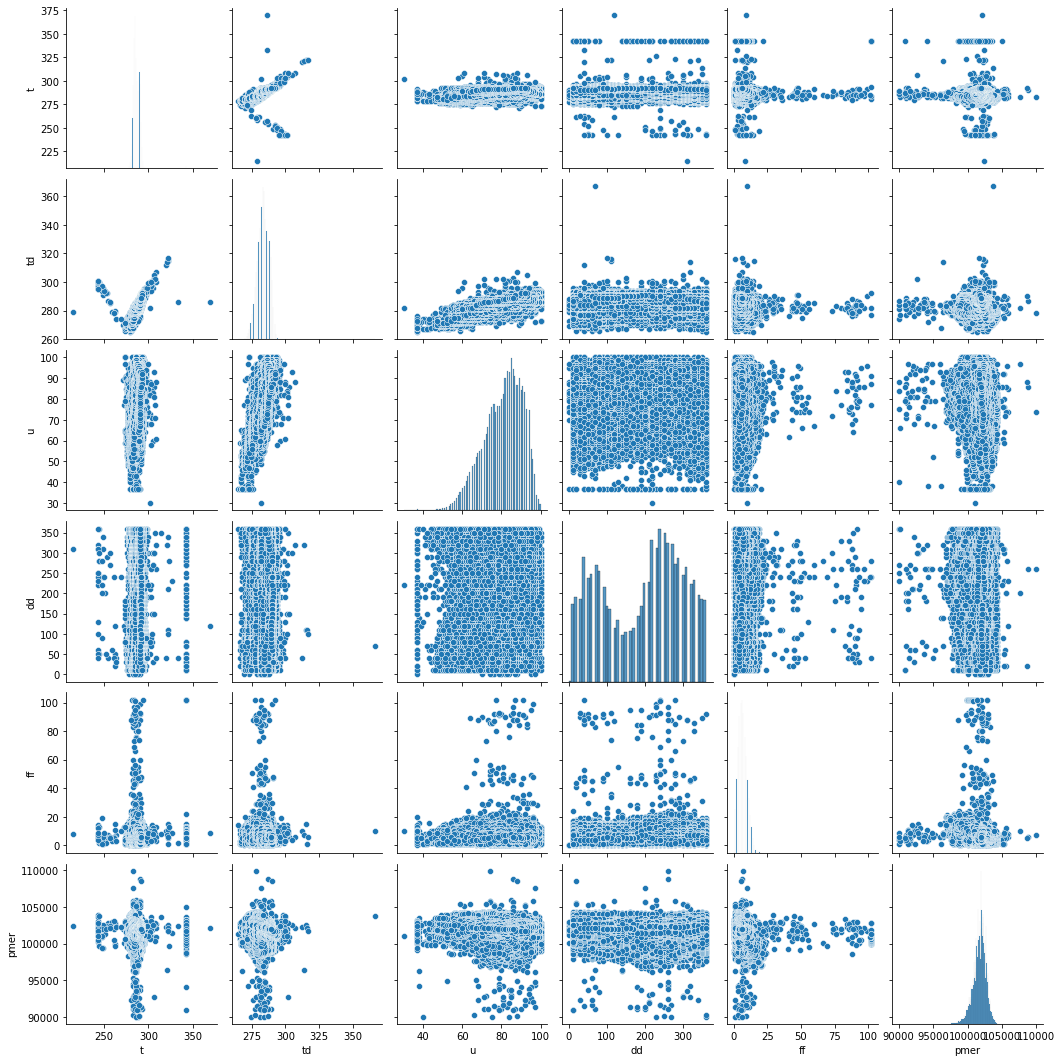

In [5]:
# We drop 'cl'

data_2=data_2.drop(['n'], axis=1)

# A fast and efficient visualization way: pairplot with seaborn !

sns.pairplot(data_2)

We could already notice maybe some signs first if we are focused on variable's distribution:

- temperature has two peaks between 275° and 300° kelvins (so between 2° and 27° celsius).

- dew index is unimodal with a peak at 280° kelvins (7° celsius).

- humidity is unimodal and left skewed (peak at 85 %).

- Wind direction is bimodal , the main peak indicates west/south west wind, and the second one east/south east.

- The wind force is dispatched on mainly four/five areas.

- Pressure is unimodal.

Now if we keep an eye on scatterplots we could see:

- A link between dew index and temperature but that's logic.

- A link between temperature and direction (at least 2 different groups).

- A link between temperature and force (between 275 and 375°K, the wind force could be more strong).

- A link between pressure and temperature (between 1000 and 1050 hpa, we have a widest range of possibility in temperature).

Conclusion: it seems to have some links beetween our variables.

Fourth step: using our homemade package to get a dataset ready for sikilearn. I let you read the notice about it. The best parameters are 3 days per row, all our variables excepted latitude and longitude (because we only have 2 different places, close so we could drop those variables). 

Here we will use machine learning to predict wind force and direction 12 hours later.

In [15]:
meteo_direction=mmc.Meteo_Marine_Classeur(data, jours=2, vue=12, cible='direction', var_corbeille=['latitude', 'longitude'])

dataset_direction=meteo_direction.data_good_shape
target_direction=meteo_direction.target

meteo_force=mmc.Meteo_Marine_Classeur(data, jours=2, vue=12, cible='force', var_corbeille=['latitude', 'longitude'])

dataset_force=meteo_force.data_good_shape
target_force=meteo_force.target

Now we split our dataset, and try it ! Because of the groups shapes seen on our scatterplots, i have chosen Randomforest model because it's efficient even if our data shapes are not linear.

In [16]:
X_train_direction, X_test_direction, y_train_direction, y_test_direction=train_test_split(dataset_direction, target_direction, random_state=77, test_size=0.2)

model_direction=RandomForestClassifier()
model_direction.fit(X_train_direction, y_train_direction)
print(model_direction.score(X_test_direction, y_test_direction))

X_train_force, X_test_force, y_train_force, y_test_force=train_test_split(dataset_force, target_force, random_state=77, test_size=0.2)

model_force=RandomForestClassifier()
model_force.fit(X_train_force, y_train_force)
print(model_force.score(X_test_force, y_test_force))

0.7632407672487833
0.7161465788720298


Not too bad ! The score looks like better for direction.

Last step: visualize the importance of our variables.

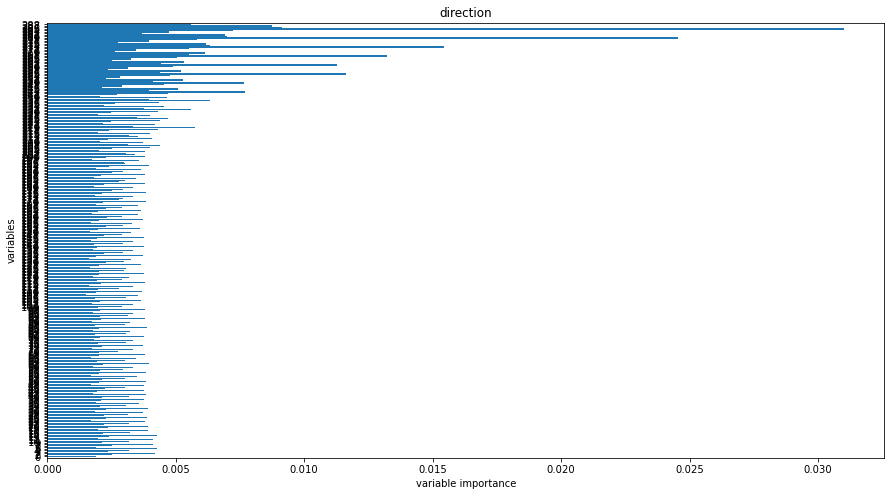

<Figure size 432x288 with 0 Axes>

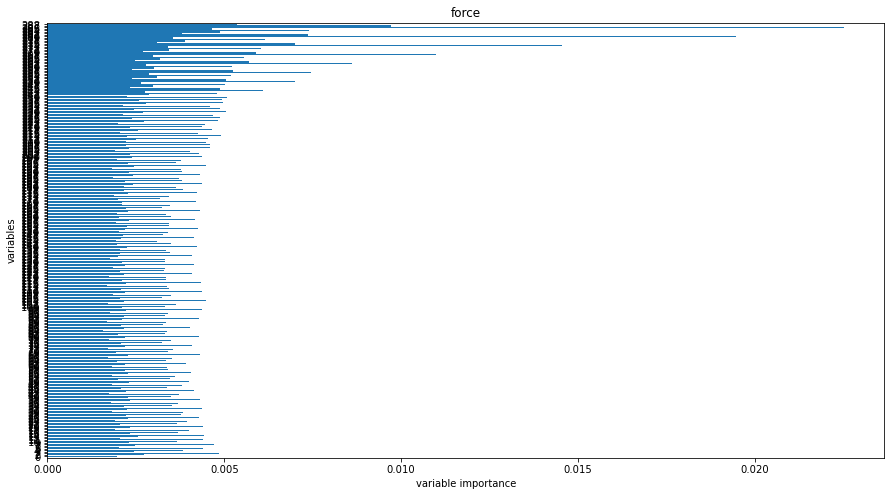

<Figure size 432x288 with 0 Axes>

In [17]:
# About direction:

def plot_var_importantes(model):
    n_features=dataset_direction.shape[1]
    plt.figure(figsize=[15, 8])
    plt.title('direction')
    plt.barh(range(n_features), model_direction.feature_importances_, align='center')
    plt.yticks(np.arange(n_features))
    plt.xlabel('variable importance')
    plt.ylabel('variables')
    plt.ylim(-1, n_features)
    plt.show()
    plt.clf()
    
plot_var_importantes(model_direction)


# About force:

def plot_var_importantes(model):
    n_features=dataset_force.shape[1]
    plt.figure(figsize=[15, 8])
    plt.title('force')
    plt.barh(range(n_features), model_force.feature_importances_, align='center')
    plt.yticks(np.arange(n_features))
    plt.xlabel('variable importance')
    plt.ylabel('variables')
    plt.ylim(-1, n_features)
    plt.show()
    plt.clf()
    
plot_var_importantes(model_force)

Conclusion: if we trim our package object 'mmc' on one or two days per row,it's easier to see that the most useful variables for our model are variables closer in time with the target (logic). It's more easy to notice that when you keep only one variable (exemple direction for direction and force to predict force).

If you trim mmc on 3 days per row with all variables, the display will not work very well on those graphs.